### Lesson 05 - Convolutional Neural Network

#### 1. Create Data Loader

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
# Download Dataset
ROOT_DATA_DIR = "FashionMNISTDir"

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor() 
)

test_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train = False, ## <<< Test data
    download = True,
    transform = transforms.ToTensor()
)

In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [5]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [6]:
# visualize one sample
def view_sample_img(data, index, label_map):
    plt.imshow(data.data[index], cmap="gray")
    plt.title(f"data label: {label_map[data.targets[index].item()]}")
    plt.axis("off")
    plt.show()

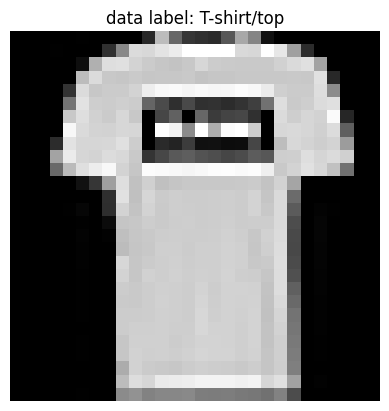

In [7]:
view_sample_img(train_data, index=1, label_map=label_map)

In [8]:
# Create the Data Loader
BATCH_SIZE = 64

train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [9]:
for data, label in test_data_loader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


#### 2. Define CNN Model Architecture

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()
        
        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)
        
    
    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)        
        x = self.FC_03(x)
        return x

In [12]:
model = CNN(1, 10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
# Count number of trainable parameters
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = 0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param = parameters.numel()
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total += param
    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total trainable parameters: {total}")
    return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [15]:
next(model.parameters()).is_cpu

True

#### 3. Train CNN Model

In [16]:
learning_rate = 0.001
num_epochs = 20

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [19]:
60000/BATCH_SIZE

937.5

In [20]:
for epoch in range(num_epochs):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            images = images.to(device)
            labels = labels.to(device)   
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 938/938 [00:34<00:00, 26.89it/s, loss=0.238] 


In [21]:
os.getcwd()

'e:\\iNeuron\\PyTorch_iNeuron_Tutorials'

In [23]:
# save trained model -
os.makedirs("2024_01_24_session_dir", exist_ok=True)
model_file = os.path.join("2024_01_24_session_dir", 'CNN_model.pth')
torch.save(model, model_file)

#### 4. Evaluate CNN Model

In [25]:
model = torch.load("2024_01_24_session_dir/CNN_model.pth")

In [26]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        image, label = data[0].to(device), data[1].to(device)
        
        y_pred = model(image)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

In [27]:
cm = confusion_matrix(target, pred)
cm

array([[904,   2,  22,  12,   2,   1,  52,   0,   5,   0],
       [  1, 971,   1,  19,   3,   0,   3,   0,   2,   0],
       [ 13,   0, 894,   7,  29,   0,  56,   0,   1,   0],
       [ 27,   0,  16, 874,  29,   0,  51,   0,   3,   0],
       [  2,   1, 105,  20, 777,   0,  94,   0,   1,   0],
       [  0,   0,   0,   0,   0, 959,   0,  22,   1,  18],
       [201,   0,  93,  20,  59,   0, 617,   0,   9,   1],
       [  0,   0,   0,   0,   0,  15,   0, 969,   0,  16],
       [  5,   5,   9,   5,   6,   2,   7,   3, 957,   1],
       [  1,   0,   0,   0,   0,   8,   0,  44,   1, 946]], dtype=int64)

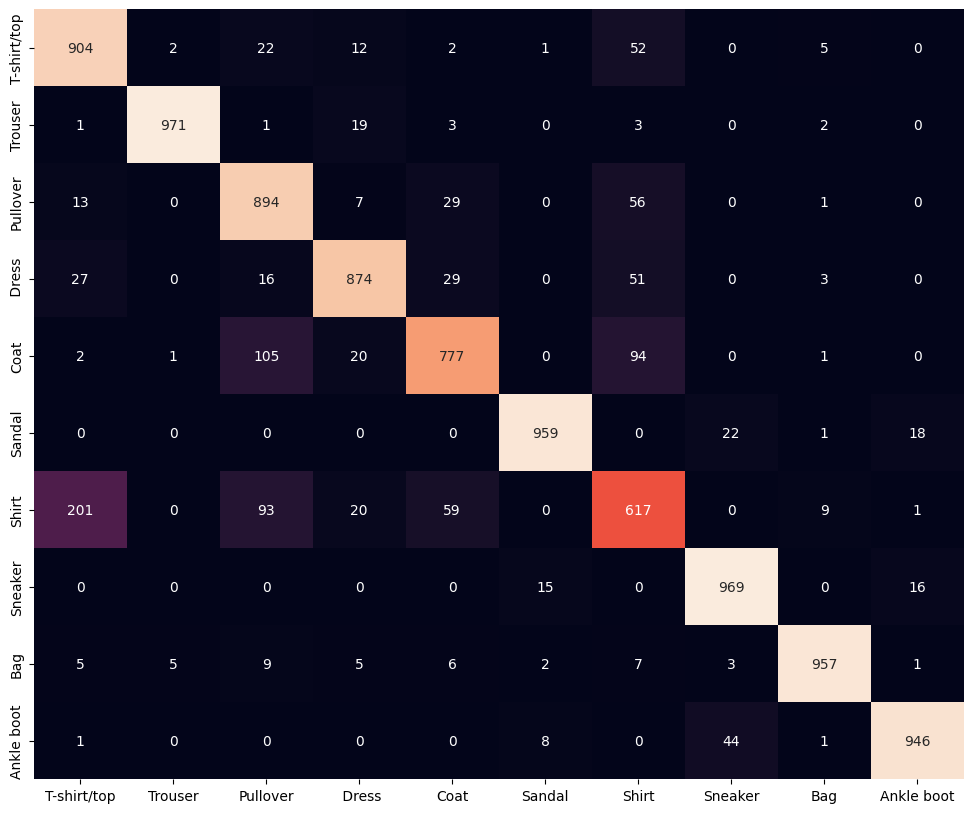

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cbar=False)
plt.show()